In [127]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.compose import ColumnTransformer
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import RandomOverSampler 
from sklearn.impute import SimpleImputer
from sklearn.metrics import accuracy_score,confusion_matrix, plot_confusion_matrix, plot_roc_curve, recall_score, f1_score, precision_score
import pandas as pd
import xgboost as xgb

In [190]:
pd.set_option("display.max_columns", None)
df_all = pd.read_parquet('./Data/modeldraft1322')
df_all.columns

Index(['Draft_Yr', 'Rnd', 'Pick', 'Tm', 'Player', 'Pos', 'Age', 'To',
       'College', 'tackles_solo', 'tackles_assists', 'tackles_total',
       'tackles_loss', 'sacks', 'def_int', 'def_int_yds',
       'def_int_yds_per_int', 'def_int_td', 'pass_defended', 'fumbles_rec',
       'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced', 'rec', 'rec_yds',
       'rec_yds_per_rec', 'rec_td', 'rush_att', 'rush_yds', 'rush_yds_per_att',
       'rush_td', 'scrim_att', 'scrim_yds', 'scrim_yds_per_att', 'scrim_td',
       'pass_cmp', 'pass_att', 'pass_cmp_pct', 'pass_yds', 'pass_yds_per_att',
       'adj_pass_yds_per_att', 'pass_td', 'pass_int', 'pass_rating', 'height',
       'weight', 'college_conference'],
      dtype='object')

In [191]:
df = df_all.drop(['To'],axis=1)

In [192]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2558 entries, 0 to 2557
Data columns (total 46 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Draft_Yr              2558 non-null   float64
 1   Rnd                   2558 non-null   float64
 2   Pick                  2558 non-null   float64
 3   Tm                    2558 non-null   object 
 4   Player                2558 non-null   object 
 5   Pos                   2558 non-null   object 
 6   Age                   2555 non-null   float64
 7   College               2554 non-null   object 
 8   tackles_solo          1182 non-null   float64
 9   tackles_assists       1182 non-null   float64
 10  tackles_total         1182 non-null   float64
 11  tackles_loss          1182 non-null   float64
 12  sacks                 1182 non-null   float64
 13  def_int               1166 non-null   float64
 14  def_int_yds           1166 non-null   float64
 15  def_int_yds_per_int  

In [174]:
type(player_names)
type(X_test)
type(y_pred)

numpy.ndarray

In [202]:
X = df.drop(['Rnd'],axis=1)
y = df.Rnd

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.45,random_state=42)

player_names = X_test.Player
player_team = X_test.Tm
player_pick = X_test.Pick
player_year = X_test.Draft_Yr

X_test = X_test.drop(['Player','Tm','College','height','Draft_Yr','Pick'],1)
X_train = X_train.drop(['Player','Tm','College','height','Draft_Yr','Pick'],1)

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)

# Separate X_train into categorical and numerical dfs
X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64'])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='constant')),
                                  ('mms',MinMaxScaler())])

transformer = ColumnTransformer(transformers=[
    ('numerical', num_transformer, X_train_num.columns),
    ('categorical', cat_transformer, X_train_cat.columns)
])

pipe = Pipeline(steps=([
    ('trans',transformer),
    ('sample',None),
    ('logr',LogisticRegression(random_state=42,solver='liblinear'))
]))

pipe.fit(X_train,y_train)

grid = {'logr__C': [1,1.25,1.1],
       'logr__fit_intercept': [True, False],
       'sample': [smote,over_samp]
       }

gridsearch = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          scoring='recall',
                          cv=5)

gridsearch.fit(X_train,y_train)

gridsearch.score(X_test, y_test)

#y_pred = pipe.predict(X_test)
y_pred = gridsearch.predict(X_test)


misclass = pd.concat([player_names, player_team, player_pick, player_year,y_test,pd.Series(y_pred),X_test],axis=1)
gridsearch.best_params_


C:\Users\capta\AppData\Local\Temp\ipykernel_23728\2657730980.py:11: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = X_test.drop(['Player','Tm','College','height','Draft_Yr','Pick'],1)
C:\Users\capta\AppData\Local\Temp\ipykernel_23728\2657730980.py:12: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = X_train.drop(['Player','Tm','College','height','Draft_Yr','Pick'],1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warni

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

{'logr__C': 1,
 'logr__fit_intercept': True,
 'sample': RandomOverSampler(random_state=42)}

In [286]:
pipe[0].transformers_[1][1].named_steps['ohe'].get_feature_names()

C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


array(['x0_DB', 'x0_DE', 'x0_DL', 'x0_DT', 'x0_FB', 'x0_K', 'x0_LB',
       'x0_LS', 'x0_OL', 'x0_P', 'x0_QB', 'x0_RB', 'x0_S', 'x0_TE',
       'x0_WR', 'x1_Atlantic Coast Conference', 'x1_Big East',
       'x1_Big Sky Conference', 'x1_Big South Conference',
       'x1_Big Ten Conference', 'x1_Big Twelve Conference',
       'x1_Canada West Universities Athletic Association',
       'x1_Colonial Athletic Association', 'x1_Conference USA',
       'x1_Great American Conference',
       'x1_Great Lakes Intercollegiate Athletic Conference',
       'x1_Great Northwest Athletic Conference', 'x1_Independent',
       'x1_Ivy League', 'x1_Lone Star Conference',
       'x1_Mid-America Intercollegiate Athletic Association',
       'x1_Mid-American Conference', 'x1_Mid-Eastern Athletic Conference',
       'x1_Missouri Valley Football Conference',
       'x1_Mountain West Conference', 'x1_NO COLLEGE',
       'x1_Northeast Conference',
       'x1_Northern Sun Intercollegiate Conference',
       'x1_O

In [287]:

feature_names = ['x0_DB', 'x0_DE', 'x0_DL', 'x0_DT', 'x0_FB', 'x0_K', 'x0_LB',
       'x0_LS', 'x0_OL', 'x0_P', 'x0_QB', 'x0_RB', 'x0_S', 'x0_TE',
       'x0_WR', 'Age', 'tackles_solo', 'tackles_assists', 'tackles_total',
       'tackles_loss', 'sacks', 'def_int', 'def_int_yds',
       'def_int_yds_per_int', 'def_int_td', 'pass_defended', 'fumbles_rec',
       'fumbles_rec_yds', 'fumbles_rec_td', 'fumbles_forced', 'rec', 'rec_yds',
       'rec_yds_per_rec', 'rec_td', 'rush_att', 'rush_yds', 'rush_yds_per_att',
       'rush_td', 'scrim_att', 'scrim_yds', 'scrim_yds_per_att', 'scrim_td',
       'pass_cmp', 'pass_att', 'pass_cmp_pct', 'pass_yds', 'pass_yds_per_att',
       'adj_pass_yds_per_att', 'pass_td', 'pass_int', 'pass_rating', 'weight','x1_Atlantic Coast Conference', 'x1_Big East',
       'x1_Big Sky Conference', 'x1_Big South Conference',
       'x1_Big Ten Conference', 'x1_Big Twelve Conference',
       'x1_Canada West Universities Athletic Association',
       'x1_Colonial Athletic Association', 'x1_Conference USA',
       'x1_Great American Conference',
       'x1_Great Lakes Intercollegiate Athletic Conference',
       'x1_Great Northwest Athletic Conference', 'x1_Independent',
       'x1_Ivy League', 'x1_Lone Star Conference',
       'x1_Mid-America Intercollegiate Athletic Association',
       'x1_Mid-American Conference', 'x1_Mid-Eastern Athletic Conference',
       'x1_Missouri Valley Football Conference',
       'x1_Mountain West Conference', 'x1_NO COLLEGE',
       'x1_Northeast Conference',
       'x1_Northern Sun Intercollegiate Conference',
       'x1_Ohio Valley Conference', 'x1_Pacific Twelve Conference',
       'x1_Patriot League', 'x1_Pennsylvania State Athletic Conference',
       'x1_Pioneer Football League',
       'x1_Rocky Mountain Athletic Conference',
       'x1_South Atlantic Conference', 'x1_Southeastern Conference',
       'x1_Southern Conference',
       'x1_Southern Intercollegiate Athletic Conference',
       'x1_Southland Conference', 'x1_Southwestern Athletic Conference',
       'x1_Sun Belt Conference', 'x1_Western Athletic Conference',
       'x1_None']

In [288]:
feature_names

['x0_DB',
 'x0_DE',
 'x0_DL',
 'x0_DT',
 'x0_FB',
 'x0_K',
 'x0_LB',
 'x0_LS',
 'x0_OL',
 'x0_P',
 'x0_QB',
 'x0_RB',
 'x0_S',
 'x0_TE',
 'x0_WR',
 'Age',
 'tackles_solo',
 'tackles_assists',
 'tackles_total',
 'tackles_loss',
 'sacks',
 'def_int',
 'def_int_yds',
 'def_int_yds_per_int',
 'def_int_td',
 'pass_defended',
 'fumbles_rec',
 'fumbles_rec_yds',
 'fumbles_rec_td',
 'fumbles_forced',
 'rec',
 'rec_yds',
 'rec_yds_per_rec',
 'rec_td',
 'rush_att',
 'rush_yds',
 'rush_yds_per_att',
 'rush_td',
 'scrim_att',
 'scrim_yds',
 'scrim_yds_per_att',
 'scrim_td',
 'pass_cmp',
 'pass_att',
 'pass_cmp_pct',
 'pass_yds',
 'pass_yds_per_att',
 'adj_pass_yds_per_att',
 'pass_td',
 'pass_int',
 'pass_rating',
 'weight',
 'x1_Atlantic Coast Conference',
 'x1_Big East',
 'x1_Big Sky Conference',
 'x1_Big South Conference',
 'x1_Big Ten Conference',
 'x1_Big Twelve Conference',
 'x1_Canada West Universities Athletic Association',
 'x1_Colonial Athletic Association',
 'x1_Conference USA',
 'x1_Gr

In [321]:
zipped = pd.DataFrame(list(zip(feature_names,coefs)))
zipped

,0,1
0,x0_DB,-2.866118
1,x0_DE,0.343861
2,x0_DL,-0.513548
3,x0_DT,-0.020697
4,x0_FB,1.671175
5,x0_K,1.436688
6,x0_LB,0.441612
7,x0_LS,0.221343
8,x0_OL,-0.356593
9,x0_P,-0.246044


In [316]:
pipe[0].transformers_[0][1].named_steps['mms'].inverse_transform(co)

ValueError: non-broadcastable output operand with shape (90,1) doesn't match the broadcast shape (90,37)

In [318]:
coefs = pipe[-1].coef_.flatten()

In [91]:
X = df.drop(['Rnd'],axis=1)
y = df.Rnd

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_names = X_test.Player
player_team = X_test.Tm
X_test = X_test.drop(['Player','Tm','College','height'],1)
X_train = X_train.drop(['Player','Tm','College','height'],1)

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64'])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='constant')),
                                  ('mms',MinMaxScaler())])

transformer = ColumnTransformer(transformers=[
    ('numerical', num_transformer, X_train_num.columns),
    ('categorical', cat_transformer, X_train_cat.columns)
])

pipe_tree = Pipeline(steps=([
    ('trans',transformer),
    ('smote',smote),
    ('forest',RandomForestClassifier(random_state=42))
]))

grid = {'forest__criterion': ['gini'],
        'forest__max_depth': [1,2,3],
        'forest__min_samples_split': [1,2,3],
        'forest__min_samples_leaf': [1],
        'forest__n_estimators': [95,100,105]
       }

gridsearch = GridSearchCV(estimator=pipe_tree,
                          param_grid=grid,
                          scoring='recall',
                          cv=5)

#pipe_tree.fit(X_train,y_train)

#y_pred = pipe_tree.predict(X_test)
gridsearch.fit(X_train,y_train)
y_pred = gridsearch.predict(X_test)
gridsearch.best_params_

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

{'forest__criterion': 'gini',
 'forest__max_depth': 2,
 'forest__min_samples_leaf': 1,
 'forest__min_samples_split': 2,
 'forest__n_estimators': 100}

In [ ]:
X = df.drop(['Rnd'],axis=1)
y = df.Rnd

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.33,random_state=42)

player_names = X_test.Player
player_team = X_test.Tm
X_test = X_test.drop(['Player','Tm','College','height'],1)
X_train = X_train.drop(['Player','Tm','College','height'],1)

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)

X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64'])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='constant')),
                                  ('mms',MinMaxScaler())])

transformer = ColumnTransformer(transformers=[
    ('numerical', num_transformer, X_train_num.columns),
    ('categorical', cat_transformer, X_train_cat.columns)
])

pipe_tree = Pipeline(steps=([
    ('trans',transformer),
    ('smote',smote),
    ('tree',DecisionTreeClassifier(random_state=42))
]))

grid = {'tree__criterion': ['gini','entropy','log_loss'],
        'tree__max_depth': [2,4,6,8,10,None],
        'tree__min_samples_split': [1,2,3,4,5],
        'tree__min_samples_leaf': [1,2,3,4,5]
       }

gridsearch = GridSearchCV(estimator=pipe_tree,
                          param_grid=grid,
                          scoring='f1',
                          cv=5)

#pipe_tree.fit(X_train,y_train)

#y_pred = pipe_tree.predict(X_test)
gridsearch.fit(X_train,y_train)
y_pred = gridsearch.predict(X_test)
gridsearch.best_params_

In [156]:
X = df.drop(['Rnd'],axis=1)
y = df.Rnd

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=.5,random_state=42)

player_names = X_test.Player
player_team = X_test.Tm
X_test = X_test.drop(['Player','Tm','College','height'],1)
X_train = X_train.drop(['Player','Tm','College','height'],1)

smote = SMOTE(random_state=42)
over_samp = RandomOverSampler(random_state=42)

# Separate X_train into categorical and numerical dfs
X_train_cat = X_train.select_dtypes('object')
X_train_num = X_train.select_dtypes(['float64'])

cat_transformer = Pipeline(steps=[('ohe',OneHotEncoder(drop='first',sparse=False,handle_unknown='ignore'))])
num_transformer = Pipeline(steps=[('impute',SimpleImputer(strategy='constant')),
                                  ('mms',MinMaxScaler())])

transformer = ColumnTransformer(transformers=[
    ('numerical', num_transformer, X_train_num.columns),
    ('categorical', cat_transformer, X_train_cat.columns)
])

pipe = Pipeline(steps=([
    ('trans',transformer),
    ('sample',None),
    ('xgb',xgb.XGBClassifier(random_state=42))
]))


grid = {"xgb__gamma": [25.5, 15.5, 35.5, 30.5],
        "xgb__learning_rate": [0.007, 0.003, 0.005],
        "xgb__max_depth": [11],
        "xgb__min_child_weight": [3],
        "xgb__n_estimators": [30, 32],
        "sample": [smote,over_samp]
       }

gridsearch = GridSearchCV(estimator=pipe,
                          param_grid=grid,
                          scoring='recall',
                          cv=5)

gridsearch.fit(X_train,y_train)

gridsearch.score(X_test, y_test)

#y_pred = pipe.predict(X_test)
y_pred = gridsearch.predict(X_test)
gridsearch.best_params_


C:\Users\capta\AppData\Local\Temp\ipykernel_23728\3455654918.py:8: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_test = X_test.drop(['Player','Tm','College','height'],1)
C:\Users\capta\AppData\Local\Temp\ipykernel_23728\3455654918.py:9: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  X_train = X_train.drop(['Player','Tm','College','height'],1)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Foun

{'sample': RandomOverSampler(random_state=42),
 'xgb__gamma': 15.5,
 'xgb__learning_rate': 0.005,
 'xgb__max_depth': 11,
 'xgb__min_child_weight': 3,
 'xgb__n_estimators': 30}

In [203]:
f1_score(y_test,y_pred)

0.3

In [204]:
accuracy_score(y_test,y_pred)

0.671875

In [205]:
recall_score(y_test,y_pred)

0.6090225563909775

In [206]:
precision_score(y_test,y_pred)

0.19901719901719903

C:\Users\capta\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function plot_confusion_matrix is deprecated; Function `plot_confusion_matrix` is deprecated in 1.0 and will be removed in 1.2. Use one of the class methods: ConfusionMatrixDisplay.from_predictions or ConfusionMatrixDisplay.from_estimator.
  warnings.warn(msg, category=FutureWarning)
C:\Users\capta\anaconda3\lib\site-packages\sklearn\preprocessing\_encoders.py:170: UserWarning: Found unknown categories in columns [1] during transform. These unknown categories will be encoded as all zeros
  warnings.warn(


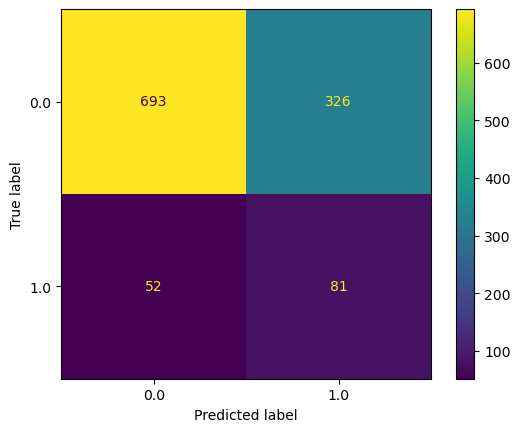

In [207]:
plot_confusion_matrix(gridsearch,X_test,y_test);

#### Columns to get from profootballreference/sportsreference
- Rnd
- Pick
- Tm
- Player
- Pos
- Age
- College/Univ
- Draft_Yr
- All college stats

#### Columns to get from NFL Python Package:
- position_group
- college_conference
- height
- weight

#### Columns to One Hot Encode 
- Pos or position_group
    - See which one works better
- college_conference

#### Columns to Transform
- Rnd needs to be turned into round 1 (target) or round 0

#### Models to try:
- Logistic Regression
- Decision Tree
- Random Forest



In [248]:
pd.set_option("display.max_rows", None)

results = pd.concat([player_year.reset_index(),player_pick.reset_index(),player_names.reset_index(),y_test.reset_index(),pd.Series(y_pred),X_test.reset_index()],axis=1).sort_values(by=['Draft_Yr','Pick'],ascending=[False,True])

In [251]:
x = results[(results[0]!=results.Rnd) & (results.Rnd == 1)]
x.Pos.value_counts()

LB    9
WR    8
TE    6
DB    5
CB    5
DT    5
S     4
OL    3
DE    3
QB    2
RB    2
Name: Pos, dtype: int64

In [260]:
results[(results.Pos == 'TE') & (results.Rnd == 1)]

,index,Draft_Yr,index,Pick,index,Player,index,Rnd,0,index,Pos,Age,tackles_solo,tackles_assists,tackles_total,tackles_loss,sacks,def_int,def_int_yds,def_int_yds_per_int,def_int_td,pass_defended,fumbles_rec,fumbles_rec_yds,fumbles_rec_td,fumbles_forced,rec,rec_yds,rec_yds_per_rec,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,pass_cmp,pass_att,pass_cmp_pct,pass_yds,pass_yds_per_att,adj_pass_yds_per_att,pass_td,pass_int,pass_rating,weight,college_conference
612,1535,2019.0,1535,8.0,1535,T.J. Hockenson,1535,1.0,0.0,1535,TE,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1080.0,14.8,9.0,1.0,4.0,4.0,1.0,74.0,1084.0,14.6,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,Big Ten Conference
781,1037,2017.0,1037,19.0,1037,O.J. Howard,1037,1.0,0.0,1037,TE,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,1726.0,15.1,7.0,NaN,NaN,NaN,NaN,114.0,1726.0,15.1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.0,Southeastern Conference
156,1041,2017.0,1041,23.0,1041,Evan Engram,1041,1.0,0.0,1041,TE,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,2320.0,14.3,15.0,NaN,NaN,NaN,NaN,162.0,2320.0,14.3,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.0,Southeastern Conference
979,1047,2017.0,1047,29.0,1047,David Njoku,1047,1.0,0.0,1047,TE,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,1060.0,16.6,9.0,NaN,NaN,NaN,NaN,64.0,1060.0,16.6,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.0,Atlantic Coast Conference
811,263,2014.0,263,10.0,263,Eric Ebron,263,1.0,0.0,263,TE,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,1805.0,16.1,8.0,2.0,7.0,3.5,NaN,114.0,1812.0,15.9,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.0,Atlantic Coast Conference
939,20,2013.0,20,21.0,20,Tyler Eifert,20,1.0,0.0,20,TE,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,1840.0,13.1,11.0,NaN,NaN,NaN,NaN,140.0,1840.0,13.1,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,Independent


In [255]:
x[x.Pos == 'TE']

,index,Draft_Yr,index,Pick,index,Player,index,Rnd,0,index,Pos,Age,tackles_solo,tackles_assists,tackles_total,tackles_loss,sacks,def_int,def_int_yds,def_int_yds_per_int,def_int_td,pass_defended,fumbles_rec,fumbles_rec_yds,fumbles_rec_td,fumbles_forced,rec,rec_yds,rec_yds_per_rec,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,pass_cmp,pass_att,pass_cmp_pct,pass_yds,pass_yds_per_att,adj_pass_yds_per_att,pass_td,pass_int,pass_rating,weight,college_conference
612,1535,2019.0,1535,8.0,1535,T.J. Hockenson,1535,1.0,0.0,1535,TE,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1080.0,14.8,9.0,1.0,4.0,4.0,1.0,74.0,1084.0,14.6,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,248.0,Big Ten Conference
781,1037,2017.0,1037,19.0,1037,O.J. Howard,1037,1.0,0.0,1037,TE,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,1726.0,15.1,7.0,NaN,NaN,NaN,NaN,114.0,1726.0,15.1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,250.0,Southeastern Conference
156,1041,2017.0,1041,23.0,1041,Evan Engram,1041,1.0,0.0,1041,TE,23.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,2320.0,14.3,15.0,NaN,NaN,NaN,NaN,162.0,2320.0,14.3,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,240.0,Southeastern Conference
979,1047,2017.0,1047,29.0,1047,David Njoku,1047,1.0,0.0,1047,TE,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,1060.0,16.6,9.0,NaN,NaN,NaN,NaN,64.0,1060.0,16.6,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,246.0,Atlantic Coast Conference
811,263,2014.0,263,10.0,263,Eric Ebron,263,1.0,0.0,263,TE,21.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,1805.0,16.1,8.0,2.0,7.0,3.5,NaN,114.0,1812.0,15.9,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,253.0,Atlantic Coast Conference
939,20,2013.0,20,21.0,20,Tyler Eifert,20,1.0,0.0,20,TE,22.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,1840.0,13.1,11.0,NaN,NaN,NaN,NaN,140.0,1840.0,13.1,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,255.0,Independent


In [257]:
df[(df.Pos == 'TE') & (df.Rnd == 1)]

,Draft_Yr,Rnd,Pick,Tm,Player,Pos,Age,College,tackles_solo,tackles_assists,tackles_total,tackles_loss,sacks,def_int,def_int_yds,def_int_yds_per_int,def_int_td,pass_defended,fumbles_rec,fumbles_rec_yds,fumbles_rec_td,fumbles_forced,rec,rec_yds,rec_yds_per_rec,rec_td,rush_att,rush_yds,rush_yds_per_att,rush_td,scrim_att,scrim_yds,scrim_yds_per_att,scrim_td,pass_cmp,pass_att,pass_cmp_pct,pass_yds,pass_yds_per_att,adj_pass_yds_per_att,pass_td,pass_int,pass_rating,height,weight,college_conference
20,2013.0,1.0,21.0,CIN,Tyler Eifert,TE,22.0,Notre Dame,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,140.0,1840.0,13.1,11.0,NaN,NaN,NaN,NaN,140.0,1840.0,13.1,11.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-6,255.0,Independent
263,2014.0,1.0,10.0,DET,Eric Ebron,TE,21.0,North Carolina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,112.0,1805.0,16.1,8.0,2.0,7.0,3.5,NaN,114.0,1812.0,15.9,8.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-4,253.0,Atlantic Coast Conference
1037,2017.0,1.0,19.0,TAM,O.J. Howard,TE,22.0,Alabama,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,114.0,1726.0,15.1,7.0,NaN,NaN,NaN,NaN,114.0,1726.0,15.1,7.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-6,250.0,Southeastern Conference
1041,2017.0,1.0,23.0,NYG,Evan Engram,TE,23.0,Mississippi,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,162.0,2320.0,14.3,15.0,NaN,NaN,NaN,NaN,162.0,2320.0,14.3,15.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-3,240.0,Southeastern Conference
1047,2017.0,1.0,29.0,CLE,David Njoku,TE,21.0,Miami (FL),NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,1060.0,16.6,9.0,NaN,NaN,NaN,NaN,64.0,1060.0,16.6,9.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-4,246.0,Atlantic Coast Conference
1296,2018.0,1.0,25.0,BAL,Hayden Hurst,TE,25.0,South Carolina,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1281.0,12.8,3.0,11.0,39.0,3.5,1.0,111.0,1320.0,11.9,4.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-4,245.0,Southeastern Conference
1535,2019.0,1.0,8.0,DET,T.J. Hockenson,TE,22.0,Iowa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,73.0,1080.0,14.8,9.0,1.0,4.0,4.0,1.0,74.0,1084.0,14.6,10.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-5,248.0,Big Ten Conference
1547,2019.0,1.0,20.0,DEN,Noah Fant,TE,21.0,Iowa,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,78.0,1083.0,13.9,19.0,4.0,NaN,NaN,NaN,82.0,1083.0,13.2,19.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-4,249.0,Big Ten Conference
2040,2021.0,1.0,4.0,ATL,Kyle Pitts,TE,20.0,Florida,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,100.0,1492.0,14.9,18.0,NaN,NaN,NaN,NaN,100.0,1492.0,14.9,18.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6-6,250.0,Southeastern Conference
